# Introduction

This project shows: 
- ability to write structured code in Python. 
- ability to use existing utilities (libraries) for processing
- preprocessing skills
- Text preprocessing:
    - lemmatization
    - working with regular expressions
    - text conversion tf-idf
- using Machine Learning models

The project includes:
1. Working with NLP:
    - Pre-processing, text transformation for Machine Learning models
2. Working with Machine Learning models:
    - Logistic Regression.
    - Decision Tree
    - Random Forest
    - XGBoost
    - LightGBM

Project of the training course "[Specialist in Data Science](https://practicum.yandex.com/data-scientist)" by [Yandex Practicum](https://practicum.yandex.com/).

# Setting up the project

In [1]:
%%html
<style>
table {float:left}
</style>

## Importing libraries

In [2]:
import numpy as np
import pandas as pd
from scipy import stats as st
import time
import warnings
import datetime
# Reading files
import os 
from pathlib import Path
import urllib
# Text preprocessing
import re
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
# Machine Learning models (Classification models)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
# Splitting data 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
# Model evaluation - classification metrics
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
# Upsampling and downsampling
from sklearn.utils import shuffle
# Sanity check 
from sklearn.dummy import DummyClassifier
# Visualization 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Setting up matplotlib

In [3]:
%matplotlib inline
small, medium, large = 14, 16, 22
params = {'figure.figsize':   (14, 5),
          'figure.titlesize': medium,
          'legend.fontsize':  small,
          'axes.titlesize':   small,
          'axes.labelsize':   small,
          'xtick.labelsize':  small,
          'ytick.labelsize':  small,
          'legend.loc':       'best'}
plt.rcParams.update(params)

In [4]:
# increasing the resolution
%config InlineBackend.figure_format = 'retina'

In [5]:
# disable warnigns
warnings.filterwarnings('ignore')

In [6]:
# removing exponential notation
pd.options.display.float_format = '{:.3f}'.format

In [7]:
# display all columns
pd.set_option('display.max_columns', None)

# Natural Language Processing

# Project "Sentiment analysis: Toxic comments identification"

## Project description

The online store is launching a new service. The store needs a tool that will detect toxic comments and send them to be edited or viewed.

## Data description

Provided data - comments with markup about the toxicity of edits.

## Task details
The customer is concerned about:
- The value of the F1 metric must be at least 75.





 |Column           |Description         |Column type
 |:---------------|:------------------------|:-------------|
 |text    | Comment|features  |
 |toxic   | Indicator whether comment is toxic or not | target |

## Objective
Build a model that will classify comments into positive and negative.

## Work plan
1. [Overview of data](#review)
2. [Data preprocessing](#dataPreprocessing)
    - [Text preprocessing with Regular Expressions](#regExpProcessing)
    - [Lemmatization](#lemmatization)
    - [Text preprocessing](#textProcessing)
    - [Data separation](#dataSeparation)
    - [Upsampling](#upsampling)
    - [Data transformation](#dataTransformation)
3. [Machine Learning models research](#MLmodelResearch)
    - [Logistic Regression](#logisticRegression)
    - [Decision Tree](#decisionTree)
    - [Random Forest](#randomForest)
    - [XGBoost](#XGBoost)
    - [LightGBM](#lightgmb)
4. [Model research results](#resultsRearchModel)
5. [Results](#results)

<a id="review"></a>
# Stage 1 - Overview of data

Reading the data and saving it in appropriate variable.

In [8]:
Path('datasets').mkdir(parents=True, exist_ok=True)

def get_file(file_name, url):
    # Check if there is a file
    if not os.path.exists(file_name):
        print(file_name,'cannot find file, file will be downloaded from URL link')
        # download the file from the url link, put it in the path file_name
        # load data using the urllib library
        _ = urllib.request.urlretrieve(url, file_name)

# Dictionary with the file name and a URL link to it
urls = {
    'comments': ('datasets/toxic_comments.csv', 'https://code.s3.yandex.net/datasets/toxic_comments.csv'),
}
[get_file(*urls[k]) for k in urls]
[get_file(urls[k][0], urls[k][1]) for k in urls]

raw_comments = pd.read_csv(urls['comments'][0],sep=',')

Let's look at our data. Display the first 10 lines.

In [9]:
raw_comments.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


Note the *\n* symbol in the text. The comments are in English.

Display general information

In [10]:
raw_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


The dataframe consists of 159571 objects. 2 columns: *text* with *object* data type and *int64* data type. There are no missing values.

Let's see how many objects are in each class *toxic*.

In [11]:
raw_comments['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

In [12]:
toxic = raw_comments[raw_comments['toxic']==1]
non_toxic = raw_comments[raw_comments['toxic']==0]

In [13]:
num_obj_in_class = pd.DataFrame(data={'class': ['toxic','non_toxic'], 'num_objects': [len(toxic), len(non_toxic)]})
num_obj_in_class

,class,num_objects
0,toxic,16225
1,non_toxic,143346


Create a function to display the graph

In [14]:
def drawPlot(df,x_axis, y_axis, x_label, y_label,plot_title):
    """
    Function for plotting graphs 
    df - dataframe
    x_axis
    y_axis
    x_label - label for x axis
    y_label - label for y axis
    plot_title - title
    """
    plt.title(plot_title)
    sns.barplot(x=x_axis,y=y_axis, data=df)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

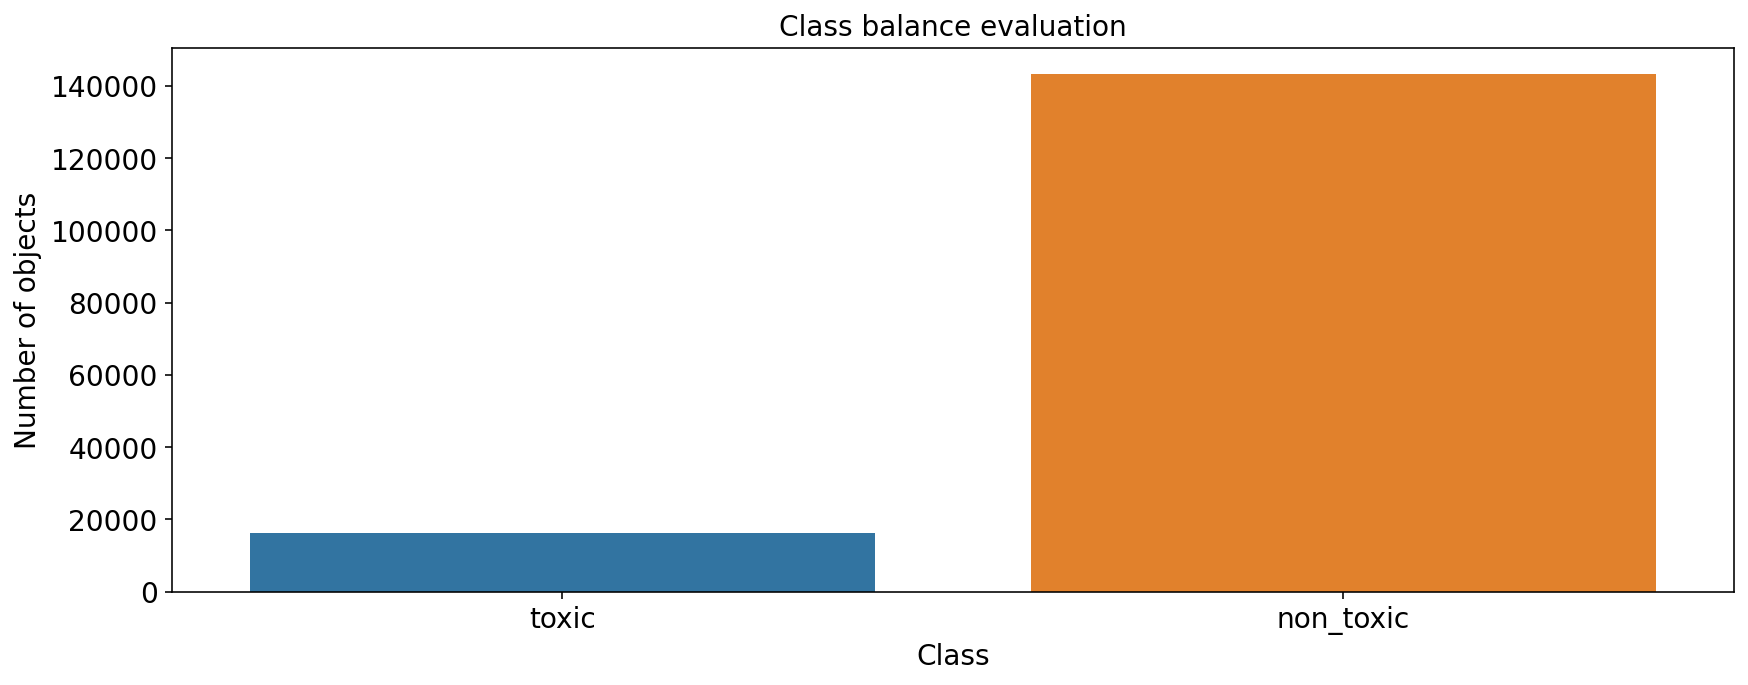

In [15]:
drawPlot(num_obj_in_class, 'class', 'num_objects', "Class", "Number of objects", "Class balance evaluation")

As you can see, the number of non-toxic comments is much higher. Consequently, we have unbalanced data.

## Summary

The dataframe consists of 159571 objects. 2 columns: *text* with *object* data type and *int64* data type. There are no missing values. The comments are in English. The number of non-toxic comments is much higher. Consequently, we have imbalanced data. We need to:
1. Preprocess data:
    - filter text using regular expressions
    - lemmatize text
    - transform text into numerical representation
2. Do a Machine Learning model research
    - find the model with best F1 metric value

<br>

<a id="dataPreprocessing"></a>
# Stage 2 - Data preprocessing

At this stage, we need to preprocess the text. Perform lemmatization. Remove special characters.

Create a corpus

In [16]:
corpus = raw_comments['text'].values

<a id="regExpProcessing"><a>
## Text preprocessing with Regular Expressions

Let's preprocess each comment with regular expressions: remove wildcards, numbers, and spaces.

In [17]:
def clear_text(text):
    """
    The function clears the text of special characters, numbers and spaces
    text - text that needs to be cleared
    """
    return " ".join(re.sub(r'[^a-zA-Z]', ' ', text).split())

Check

In [18]:
corpus[1]

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

In [19]:
clear_text(corpus[1])

'D aww He matches this background colour I m seemingly stuck with Thanks talk January UTC'

<a id="lemmatization"></a>
## Lemmatization

Let's lemmatize each comment

In [20]:
# create lemmatizer
lemmatizer = WordNetLemmatizer()

In [21]:
def lemmatize(text):
    """
    Function lemmatizes text
    text - text that needs to be lemmatized
    """
    # tokenize text
    word_list = nltk.word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(word) for word in word_list]
    return " ".join(lemmatized)

Check

In [22]:
corpus[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [23]:
lemmatize(clear_text(corpus[0]))

'Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They weren t vandalism just closure on some GAs after I voted at New York Dolls FAC And please don t remove the template from the talk page since I m retired now'

<a id="textProcessing"></a>
## Text preprocessing

Let's preprocess each comment.

In [24]:
processed_corpus = []

In [25]:
for comment in corpus: 
    processed_corpus.append(lemmatize(clear_text(comment)))

In [26]:
cleared = pd.Series(processed_corpus)

We have pre-processed the text, now let's split the data.

<a id="dataSeparation"></a>
## Data separation

We need to check the accuracy of the model. Thus, we have to split the data for cross-validation. We will split the original data into 2 samples: training and test in ratio (*75/25*). Validation sample will be generated in the cross-validation.

Split target and features

In [27]:
features = cleared
target = raw_comments['toxic']

Fix ***random_state***.

In [28]:
random_state_value = 42

In sklearn, there is a functon for sample splitting *train_test_split()*. We will write a functon for sample splitting and displaying the sizes of resulted samples, to avoid errors.

In [29]:
def sampleSize(original, train, test):
    """
    Function for displaying the sizes of resulted samples
    original - original data
    train - training sample
    test - test sample
    """
    print(f'Size of the original data: {len(original)}')
    print(f'Size of the training sample:  {len(train)}')
    print(f'Size of the test sample: {len(test)}')

In [30]:
def cross_val_splitting_data(target,features):
    """
    Function for splitting data into training and test samples. It returns targets, and features of training and test samples
    target
    features
    """
    features_train, features_test, target_train, target_test = train_test_split(features, target,random_state=random_state_value,test_size=0.25)
    # checks sizes of samples
    sampleSize(features,features_train,features_test)
    return features_train,target_train, features_test, target_test

In [31]:
features_train, target_train, features_test, target_test = cross_val_splitting_data(target,features)

Size of the original data: 159571
Size of the training sample:  119678
Size of the test sample: 39893


In the overview data stage, we noticed that we have a class imbalance. If we do downsampling, we will lose data. Hence we do upsampling

<a id="upsampling"></a>
## Upsampling

Write a function to upsample our data to have balanced classes

In [32]:
def upsample(features, target,repeat,sample_name):
    """
    Function does upsampling. Returns upsampled data
    features 
    target 
    repeat - how many times to repeat the positive class
    sample_name 
    """
    # we divide the training sample into negative and positive objects.
    features_zeros = features[target==0]
    features_ones = features[target==1]
    target_zeros = target[target==0]
    target_ones = target[target==1]
    # We duplicate the objects of the positive class and merge them with the objects of the negative class.
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    # shuffle the data
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=random_state_value)
    # Print Ratio - Check
    print(f'Ration {sample_name}')
    print(target_upsampled.value_counts())
    return features_upsampled, target_upsampled

In [33]:
features_train, target_train = upsample(features_train, target_train, 8, "Training sample")

Ration Training sample
0    107512
1     97328
Name: toxic, dtype: int64


Let's transform the texts into vectors.

<a id= "dataTransformation"></a>
## Data transformation

In [34]:
# download stopwords
stopwords = stopwords.words('english')

In [35]:
# create tf-idf
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
# train
count_tf_idf.fit(features_train)
# transform
features_train = count_tf_idf.transform(features_train)
features_test = count_tf_idf.transform(features_test)

## Summary
At this stage we preprocessed the texts: 
- made lemmatization
- removed special characters, numbers. 
- vectorized the texts. 
- divided the sample into 75/25 - (training and test sample).

The data is ready for further work

<a id="MLmodelResearch"></a>
# Stage 3 - Machine Learning model research
We have 5 models to solve our problem (binary classification):
1. Decision tree
2. Random forest
3. Logistic regression
4. XGBoost
5. LightGBM

Let's find the hyperparameters and see the values of the metrics: 
1. Recall (completeness)
2. precision (accuracy)
3. F1 score
4. Accuracy
5. AUC-ROC

Let's also look at the balance of classes with *confusion_matrix*.

We will keep track of machine learning models. We will create a list of models using a dictionary. Then from the dictionary we will convert the model table with all the metrics. 

In [36]:
ml_models_stats = dict()

Let's write a function to evaluate the models. Also, we will write helper functions such as displaying the graphs.

In [37]:
def drawErrorMatrix(error_matrix, model_name):
    """
    Function draws Error matrix
    error_matrix 
    model_name 
    """
    plt.title(f'Матрица ошибок модели: {model_name}')
    sns.heatmap(error_matrix, annot=True,cmap='BuPu',cbar=False,fmt="d")
    plt.xlabel('Predictions')
    plt.ylabel('Answers')
    plt.show()

In [38]:
def drawPR_curve(target,features,model):
    """
    Function draws Recall-Precision curve graph
    target 
    features
    model
    """
    # calculate the probabilities of classes 
    probabilities = model.predict_proba(features)
    # calculate precision, recall to build the graph
    precision,recall, thresholds = precision_recall_curve(target, probabilities[:,1])
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Curve Precision-Recall')
    plt.show()

In [39]:
def drawROC_curve(target,features,model):
    """
    Function draws ROC-curve graph and calculates AUC-ROC area
    target 
    features 
    model
    """
    # calculate the probabilities of classes 
    probabilities = model.predict_proba(features)
    # calculate precision, recall to build the graph
    fpr, tpr, thresholds = roc_curve(target, probabilities[:,1])
    # calculate AUC-ROC area
    auc_roc = roc_auc_score(target, probabilities[:,1])
    # Build the graph
    plt.plot(fpr,tpr)
    # ROC-curve of random model
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-curve')
    plt.show()
    return auc_roc
    

In [40]:
def evaluate_model(model_name, model, train_score, features_test, target_test,parameters=None):
    """
    Function evaluates model on metrics, adds model to the table with metrics.
    model_name 
    model 
    train_score - accuracy on training sample
    features_test - features of test sample
    target_test - target of test sample
    parameters 
    """
    print(f'Evaluation of the model: {model_name}')
    if parameters:
        print(f'with parameters: {parameters}')
    
    print(f'Model accuracy on train sample: {train_score}')
    # Evaluating the accuracy of the model on the test sample
    test_score = model.score(features_test,target_test)
    print(f'Model accuracy on test sample: {test_score}')
    # Generating predictions
    predictions_test = model.predict(features_test)
    # Error matrix
    error_matrix = confusion_matrix(target_test,predictions_test)
    # Recall 
    recall = recall_score(target_test, predictions_test)
    # Precision
    precision = precision_score(target_test, predictions_test)
    # F1 - Score
    f1_Score = f1_score(target_test, predictions_test)
    print()
    # Draw error matrix
    drawErrorMatrix(error_matrix,model_name)
    print()
    # Draw Precision-Recall curve
    drawPR_curve(target_test, features_test, model)
    print()
    # Draw ROC-curve and calculate AUC-ROC area
    auc_roc_score = drawROC_curve(target_test, features_test, model)
    print()
    print(f'Recall - {recall}')
    print(f'Precision - {precision}')
    print(f'F1-Score - {f1_Score}')
    print(f'AUC-ROC_score - {auc_roc_score}')
    # добаляем модель
    ml_models_stats[model_name] = {
        'name': model_name,
        'train_score': train_score,
        'test_score':test_score,
        'recall':recall,
        'precision':precision,
        'f1_score':f1_Score,
        'auc_roc_score':auc_roc_score
    }
    print()
    print('Model has been successfully added!')

Let's start by checking **"Logistic regression" or "Logistic regression "**

<a id="logisticRegression"></a>
### Logistic Regression

In [41]:
%%time
# parameters
gs_params = {
    'solver': ['liblinear', 'sag','saga','newton-cg'],
    'C': [0.5,1.0,1.5],
    'intercept_scaling':[0.5,1.0,1.5]
}
# create RandomizedSearchCV
gs_logistic = RandomizedSearchCV(LogisticRegression(random_state=random_state_value),gs_params,scoring='f1',cv=5, n_iter=20)
# Train model
gs_logistic.fit(features_train,target_train)

CPU times: user 9min 8s, sys: 11min 36s, total: 20min 45s
Wall time: 7min 24s


Evaluation of the model: Logistic Regression
with parameters: {'solver': 'saga', 'intercept_scaling': 0.5, 'C': 1.5}
Model accuracy on train sample: 0.9634236081464621
Model accuracy on test sample: 0.9468327776802948



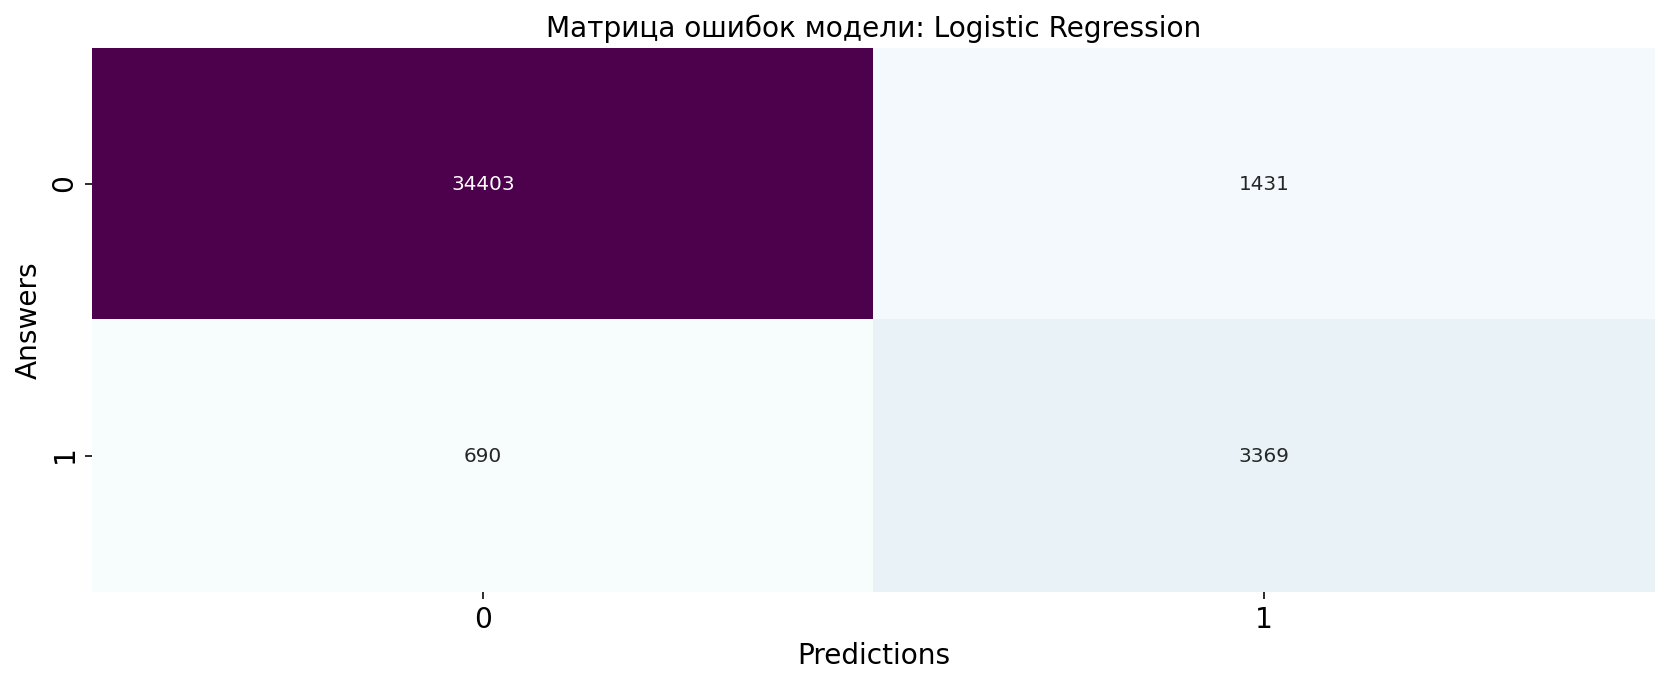

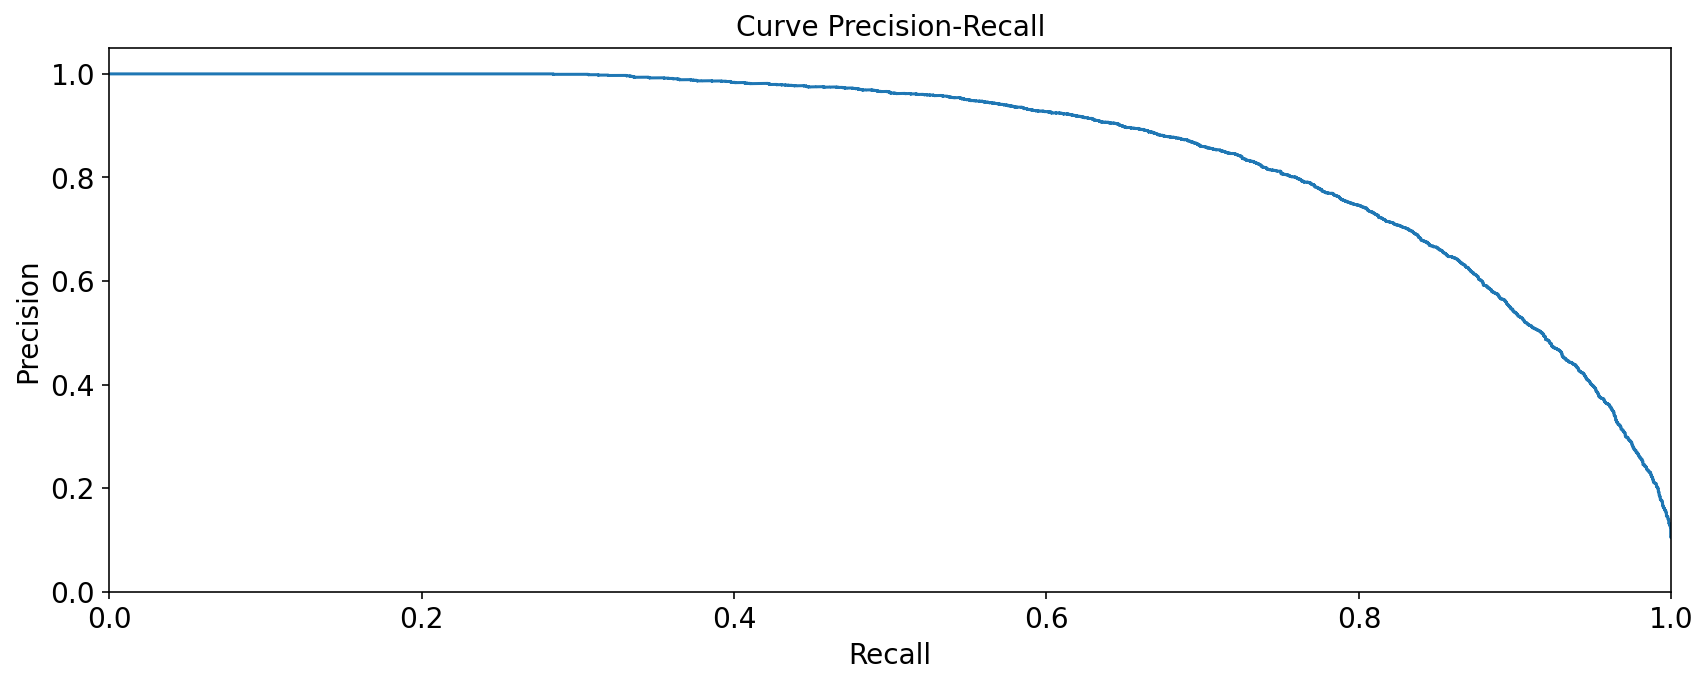

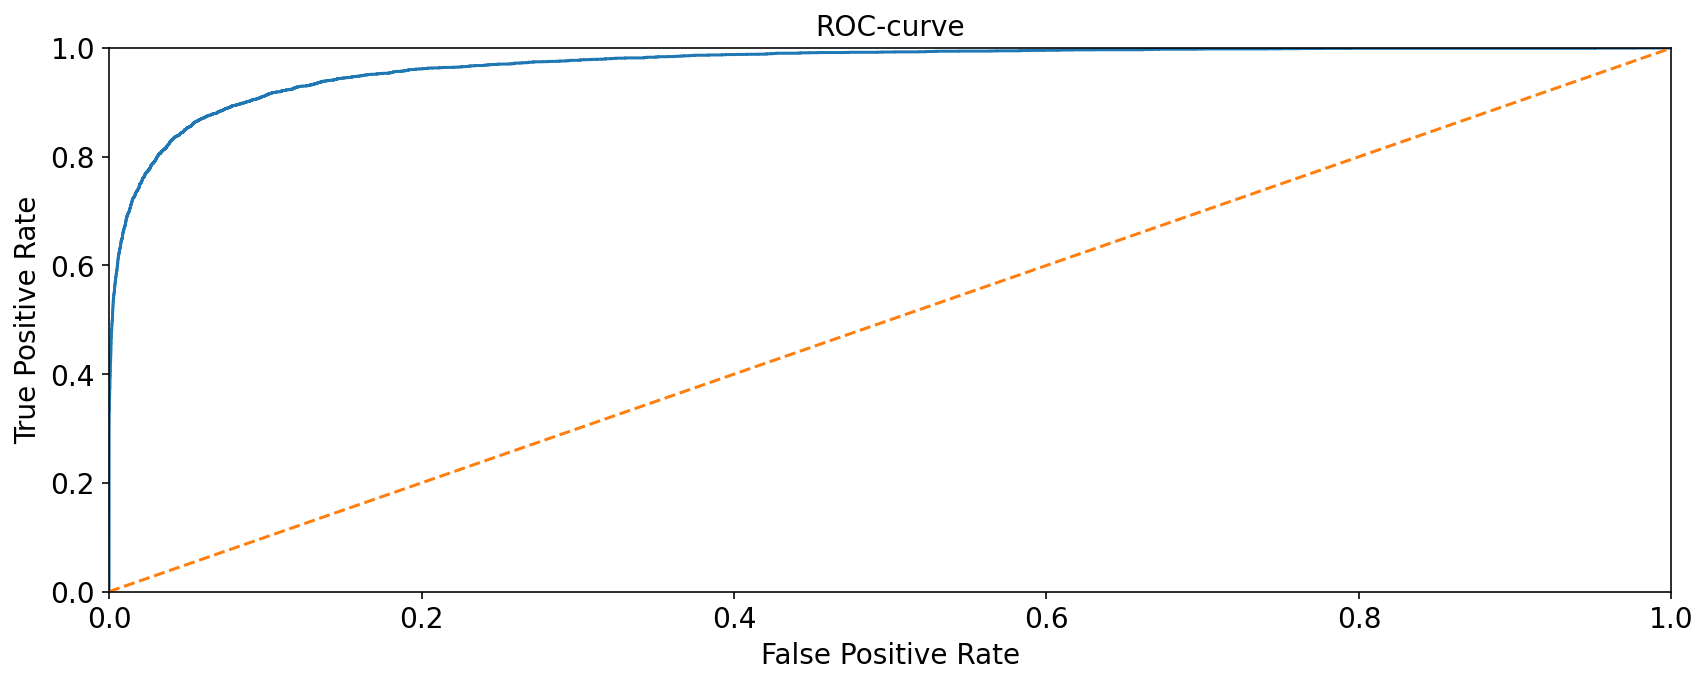


Recall - 0.8300073909830007
Precision - 0.701875
F1-Score - 0.7605824585167626
AUC-ROC_score - 0.9689416699760466

Model has been successfully added!


In [42]:
evaluate_model("Logistic Regression", gs_logistic.best_estimator_, gs_logistic.best_score_, features_test, target_test,gs_logistic.best_params_)

The model showed a good score on the F1-score metric - **0.75**. Let's move on to the decision tree.

<a id="decisionTree"></a>
### Decision Tree

In [43]:
%%time
# parameters
gs_params = {
    'max_depth': range(1, 11),
    'min_samples_leaf':range(1,11)
}
# create RandomizedSearchCV
gs_tree = RandomizedSearchCV(DecisionTreeClassifier(random_state=random_state_value),gs_params,scoring='f1',cv=5, n_iter=20)
# Train model
gs_tree.fit(features_train,target_train)

CPU times: user 27min 51s, sys: 1.53 s, total: 27min 53s
Wall time: 27min 48s


Evaluation of the model: Decision Tree
with parameters: {'min_samples_leaf': 6, 'max_depth': 10}
Model accuracy on train sample: 0.5921873028892098
Model accuracy on test sample: 0.9353269997242624



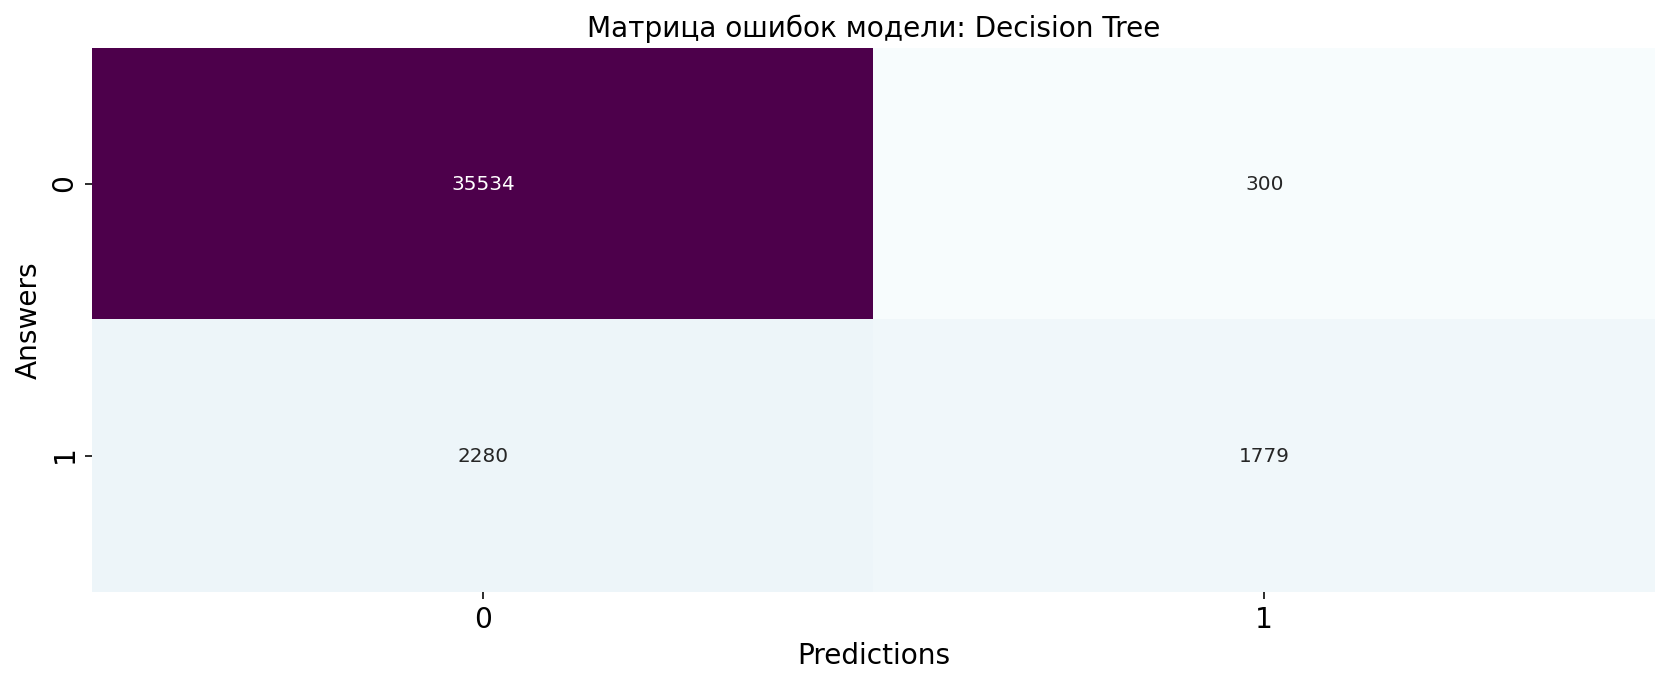

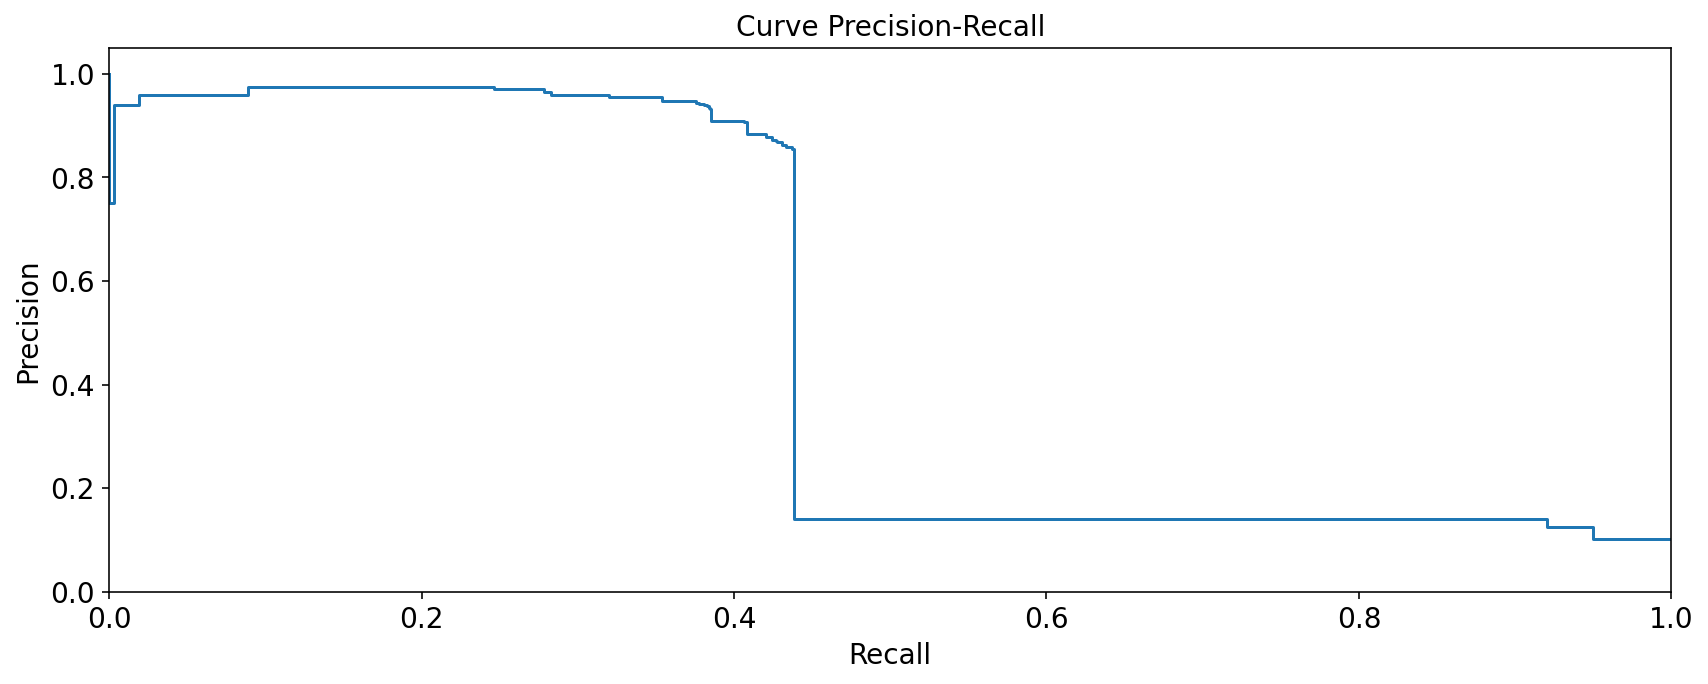

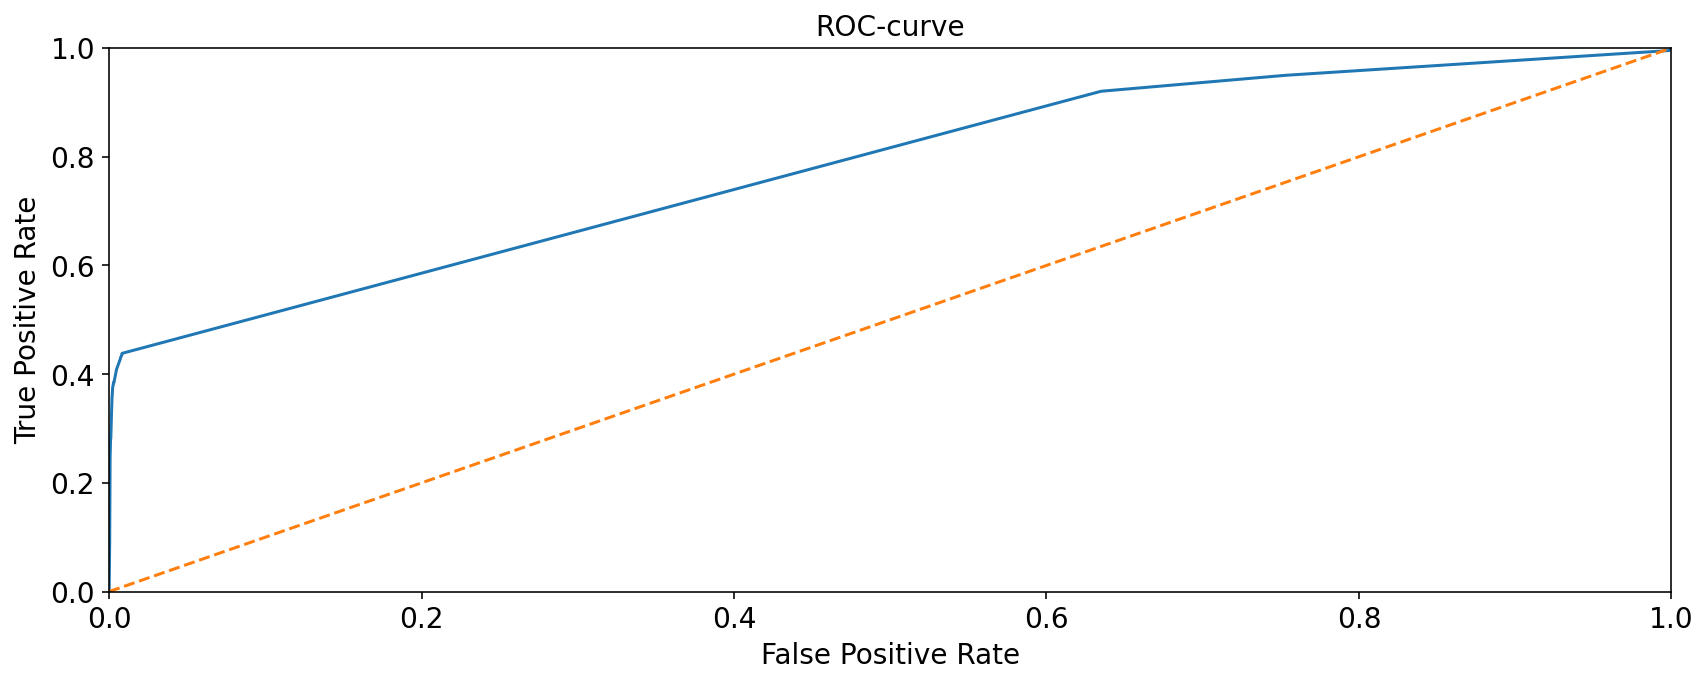


Recall - 0.43828529194382854
Precision - 0.8556998556998557
F1-Score - 0.5796676441837731
AUC-ROC_score - 0.7793671292565925

Model has been successfully added!


In [44]:
evaluate_model("Decision Tree", gs_tree.best_estimator_, gs_tree.best_score_, features_test, target_test,gs_tree.best_params_)

The F1-score metric has dropped to **0.55**. Let's look at Random Forest

<a id="randomForest"></a>
## Random Forest

In [45]:
%%time
# parameters
rs_params = {
    'max_depth': range(1, 26),
    'min_samples_leaf':range(1,11)
}
# create RandomizedSearchCV
forest_balanced_rs = RandomizedSearchCV(RandomForestClassifier(random_state=random_state_value),rs_params,scoring='f1',cv=5, n_iter=20)
# train model
forest_balanced_rs.fit(features_train, target_train)

CPU times: user 1h 9min 23s, sys: 12.6 s, total: 1h 9min 35s
Wall time: 1h 9min 25s


Evaluation of the model: Random Forest
with parameters: {'min_samples_leaf': 2, 'max_depth': 22}
Model accuracy on train sample: 0.8418709158387404
Model accuracy on test sample: 0.8802797483267741



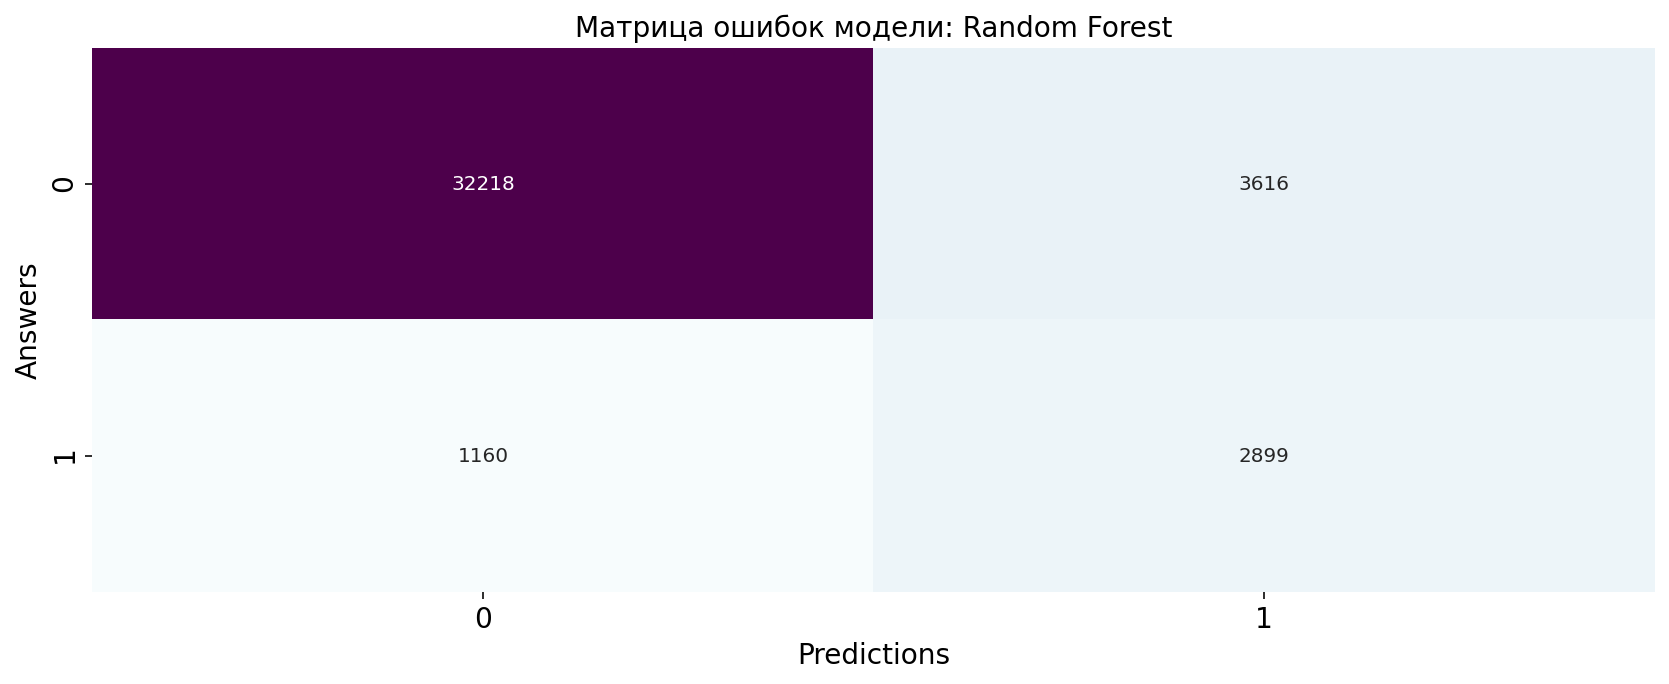

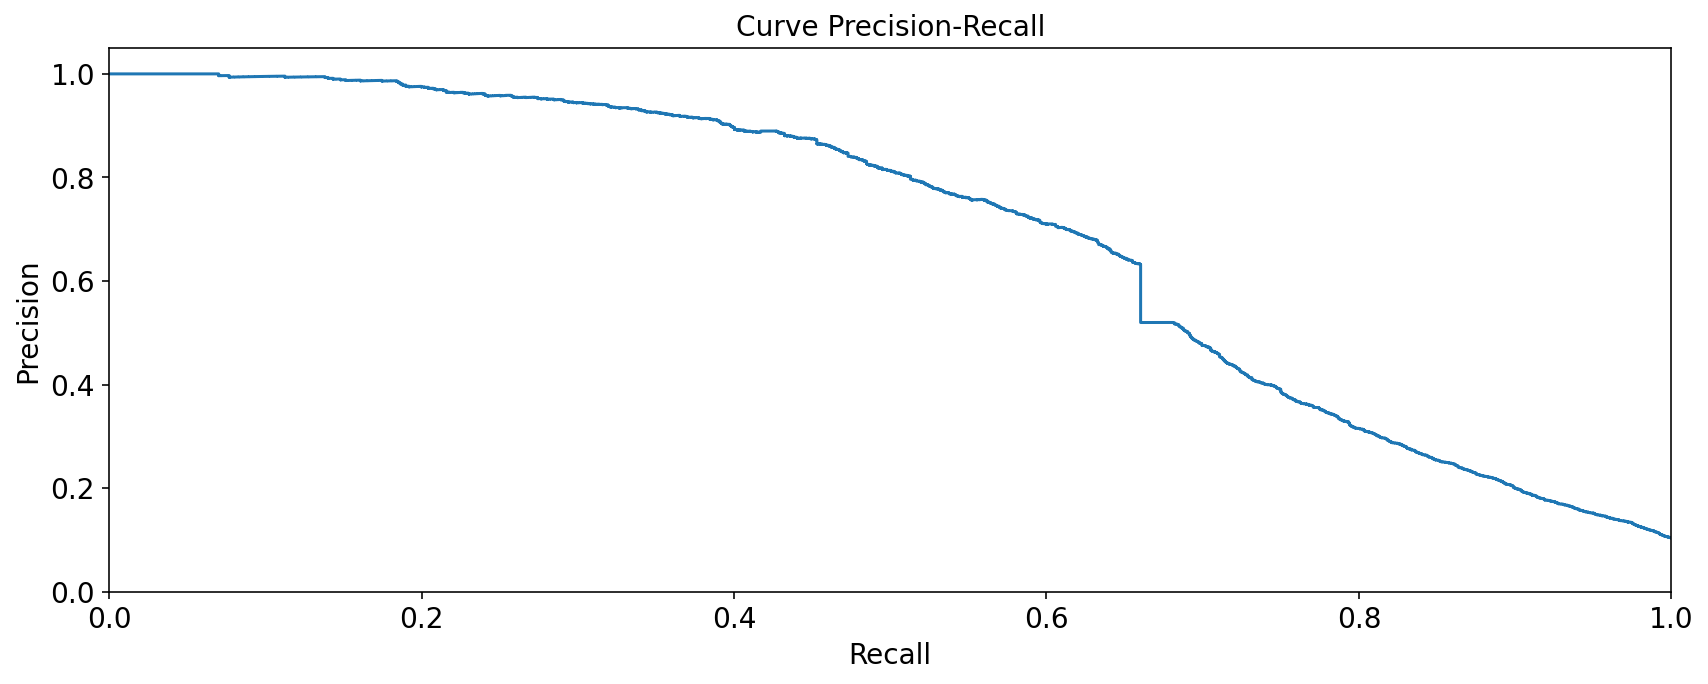

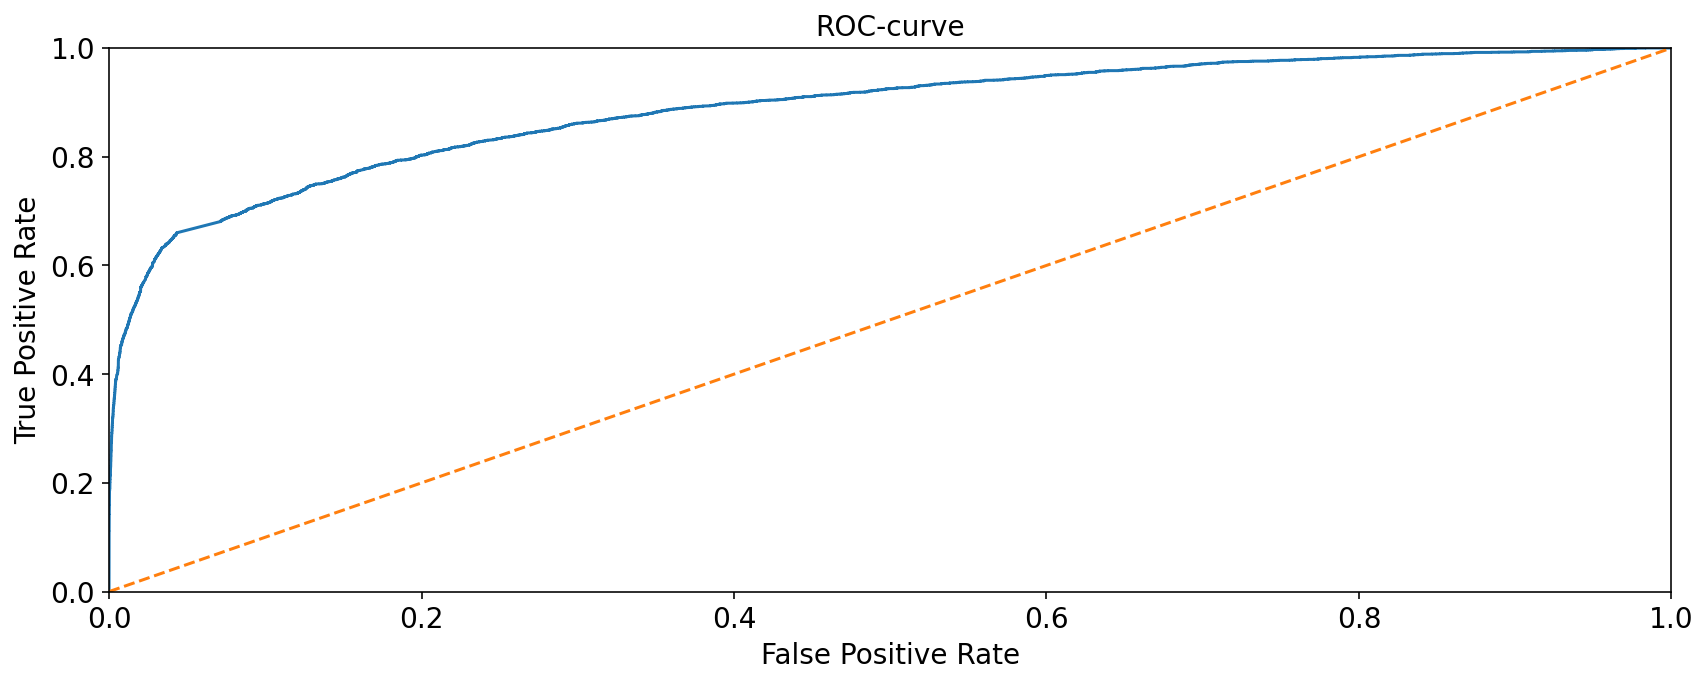


Recall - 0.7142153239714215
Precision - 0.44497313891020723
F1-Score - 0.5483260828447135
AUC-ROC_score - 0.8867036805709304

Model has been successfully added!


In [46]:
evaluate_model("Random Forest", forest_balanced_rs.best_estimator_, forest_balanced_rs.best_score_, features_test, target_test,forest_balanced_rs.best_params_)

So far, the best model is Logistic Regression. The random forest, the F1-score value is **0.53**. Let's move on to boosting.

<a id="XGBoost"></a>
## XGBoost

In [47]:
%%time
xgb_params = {
    "max_depth": range(3, 10,2),
    "min_child_weight": range(1,6,2)
}
xgb = xgb.XGBClassifier(nthread=-1) 
xgb_gs = RandomizedSearchCV(xgb, xgb_params, scoring='f1',n_jobs=-1, n_iter=20)
xgb_gs.fit(features_train,target_train)

CPU times: user 6min 24s, sys: 2.53 s, total: 6min 26s
Wall time: 56min 31s


Evaluation of the model: XGBoost
with parameters: {'min_child_weight': 1, 'max_depth': 9}
Model accuracy on train sample: 0.8541603969120125
Model accuracy on test sample: 0.9461810342666633



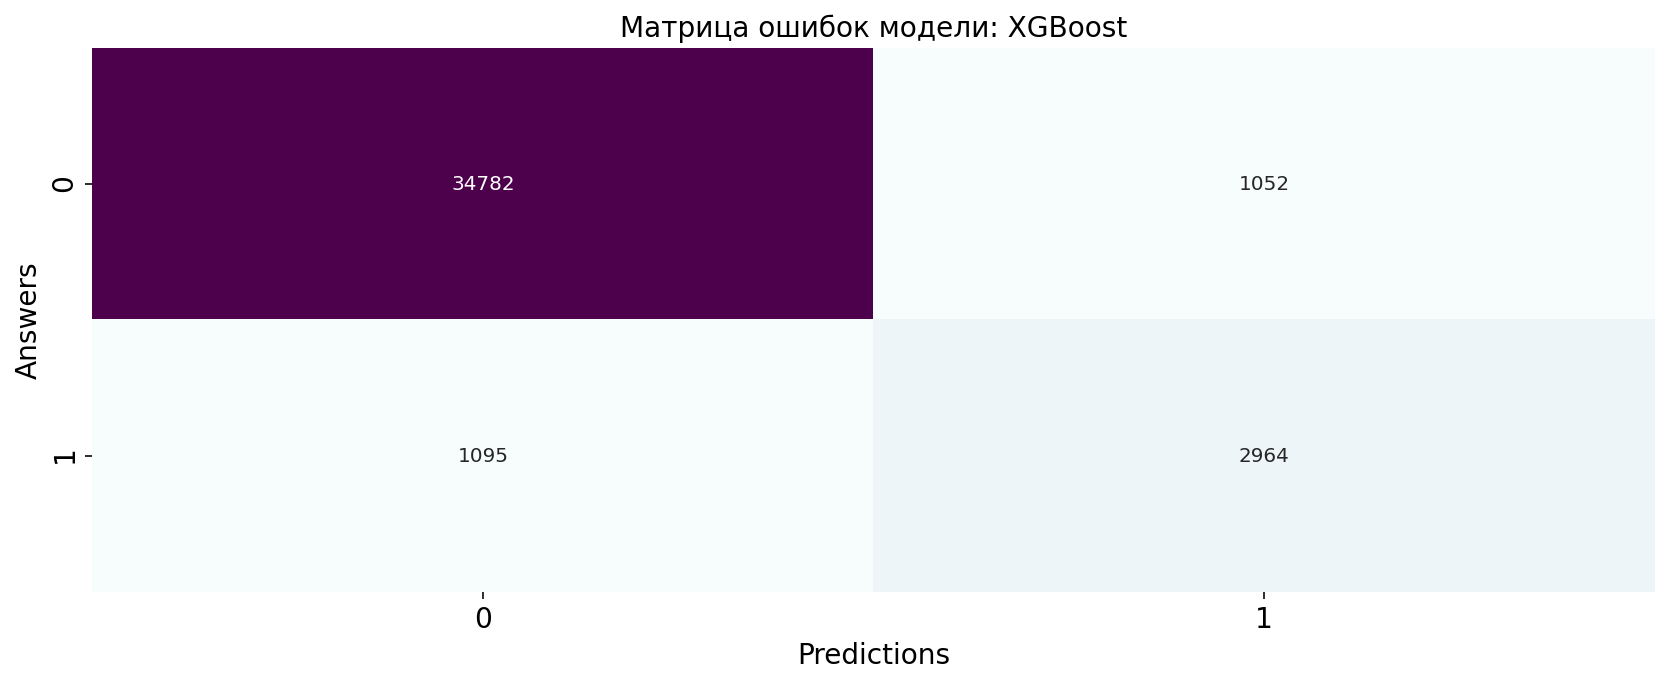

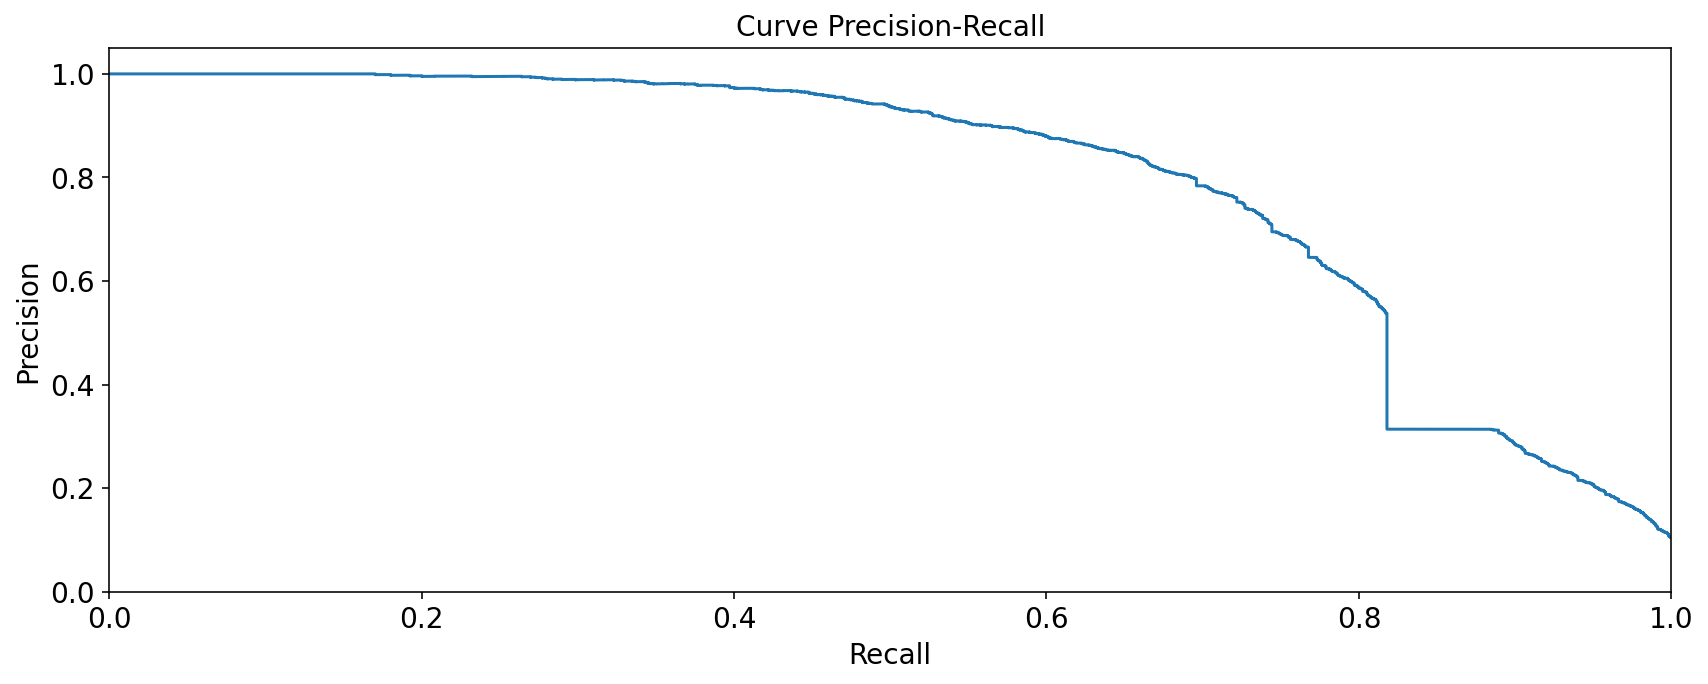

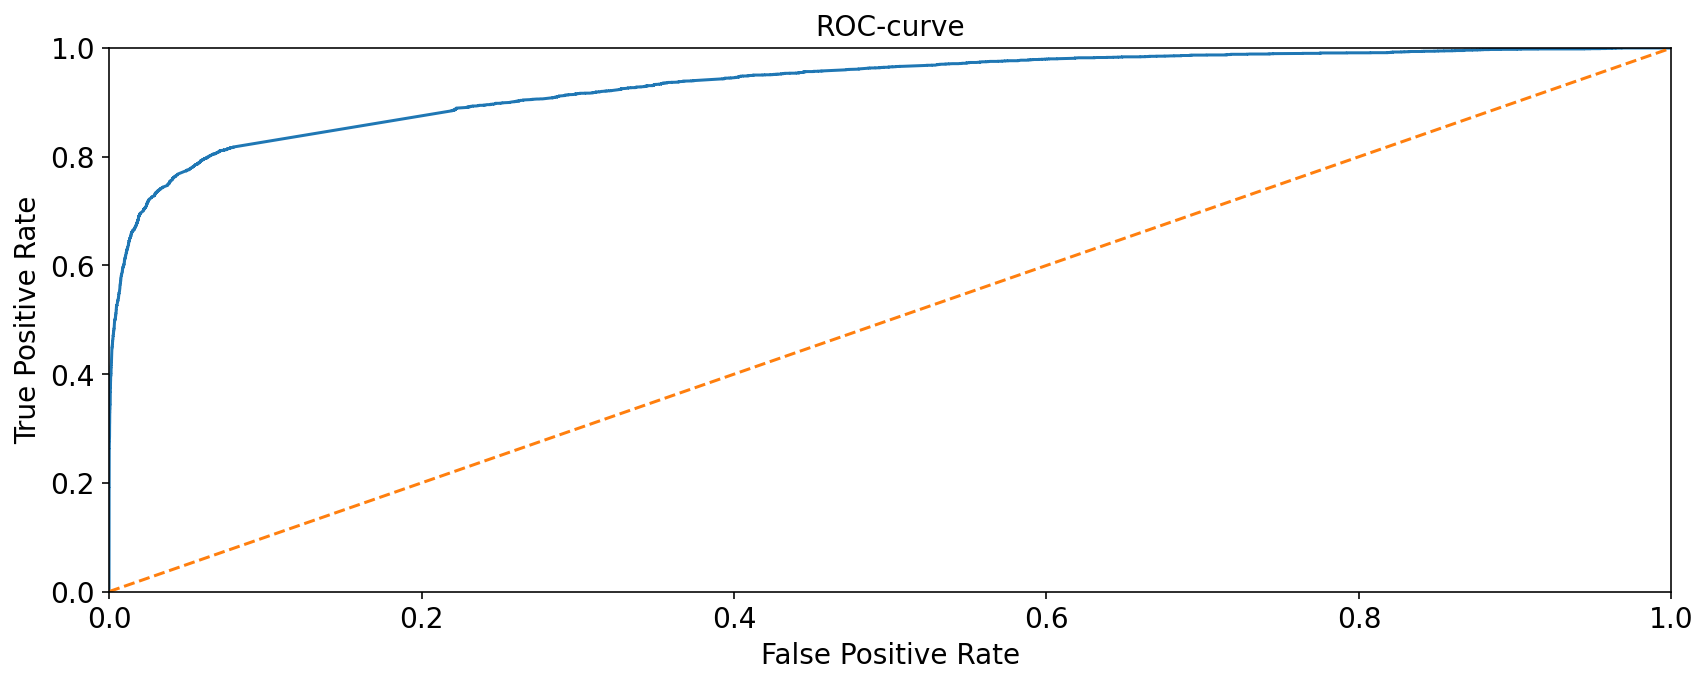


Recall - 0.7302291204730229
Precision - 0.7380478087649402
F1-Score - 0.7341176470588235
AUC-ROC_score - 0.9318831628193087

Model has been successfully added!


In [48]:
evaluate_model("XGBoost", xgb_gs.best_estimator_, xgb_gs.best_score_, features_test, target_test,xgb_gs.best_params_)

XGBoost showed good result on F1-score - **0.71**. Let's proceed to LightGBM.

<a id="lightgmb"></a>
## LightGBM

In [51]:
%%time
lgb_params = {
    'objective': ['regression','binary'],
    'boosting_type' : ['dart','gbdt','goss'],
    'max_depth': [15,30],
    'num_leaves': [10,200,250]
}
lgb_reg = lgb.LGBMClassifier(random_state=random_state_value)
lgb_rs = RandomizedSearchCV(lgb_reg, lgb_params,scoring='f1', cv=5, n_iter=20)
lgb_rs.fit(features_train,target_train)

CPU times: user 5h 32min 37s, sys: 1min 3s, total: 5h 33min 41s
Wall time: 1h 26min 40s


Evaluation of the model: LightGBM
with parameters: {'objective': 'regression', 'num_leaves': 200, 'max_depth': 30, 'boosting_type': 'gbdt'}
Model accuracy on train sample: 0.9319440011370407
Model accuracy on test sample: 0.9468578447346653



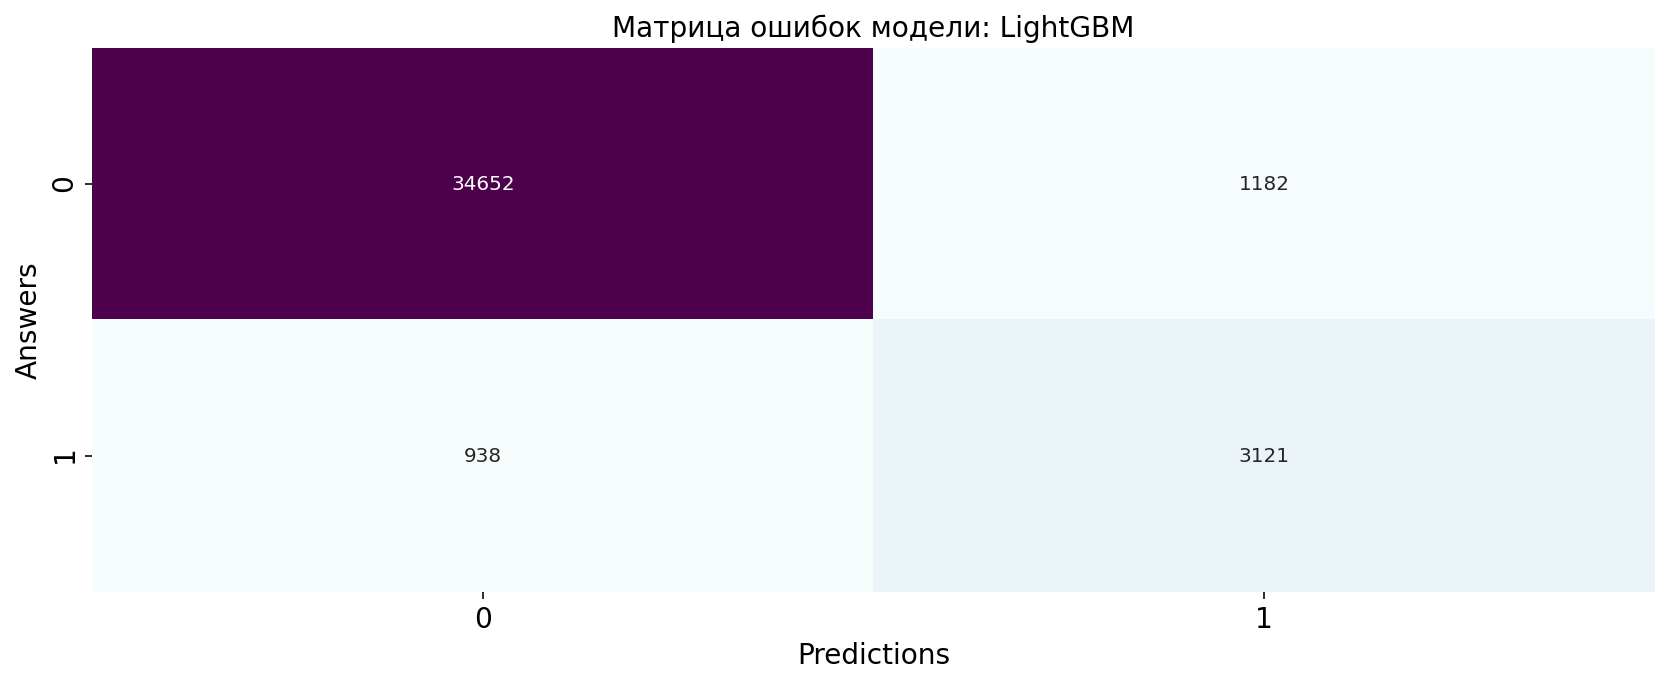

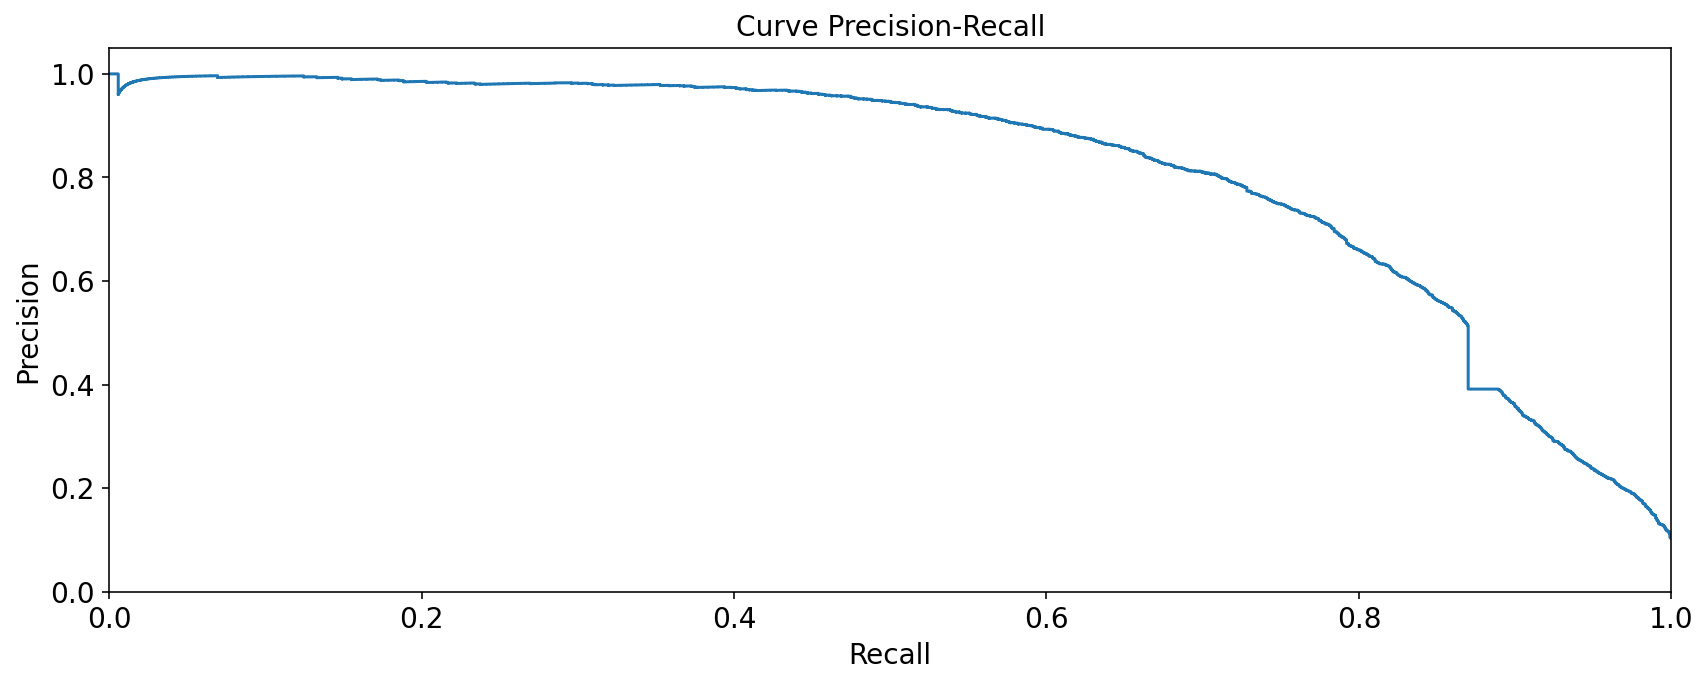

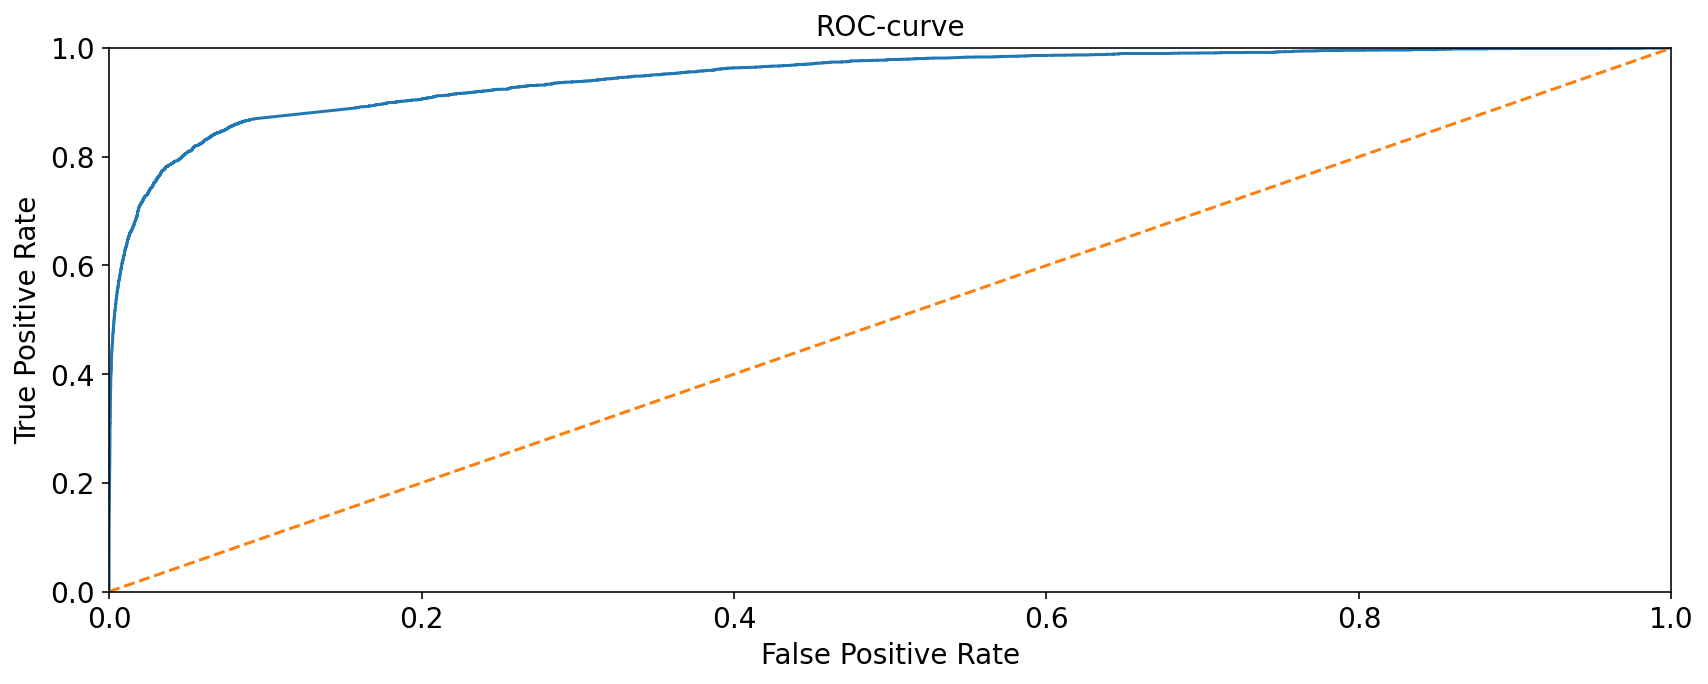


Recall - 0.7689085981768908
Precision - 0.7253079247036951
F1-Score - 0.7464721358526669
AUC-ROC_score - 0.9467790956583451

Model has been successfully added!


In [52]:
evaluate_model("LightGBM", lgb_rs.best_estimator_, lgb_rs.best_score_, features_test, target_test,lgb_rs.best_params_)

The model showed a good result on the F1-score metric - **0.74**. We need to check the models for sanity. Train the dummy model.

<a id="dummy"></a>
## DummyClassifier

In [53]:
%%time
dummy_model = DummyClassifier(strategy='constant',constant=1, random_state=random_state_value)
dummy_model.fit(features_train,target_train)

CPU times: user 14.3 ms, sys: 0 ns, total: 14.3 ms
Wall time: 13.7 ms


Evaluation of the model: Dummy constant
Model accuracy on train sample: 0.4751415739113454
Model accuracy on test sample: 0.10174717368961973



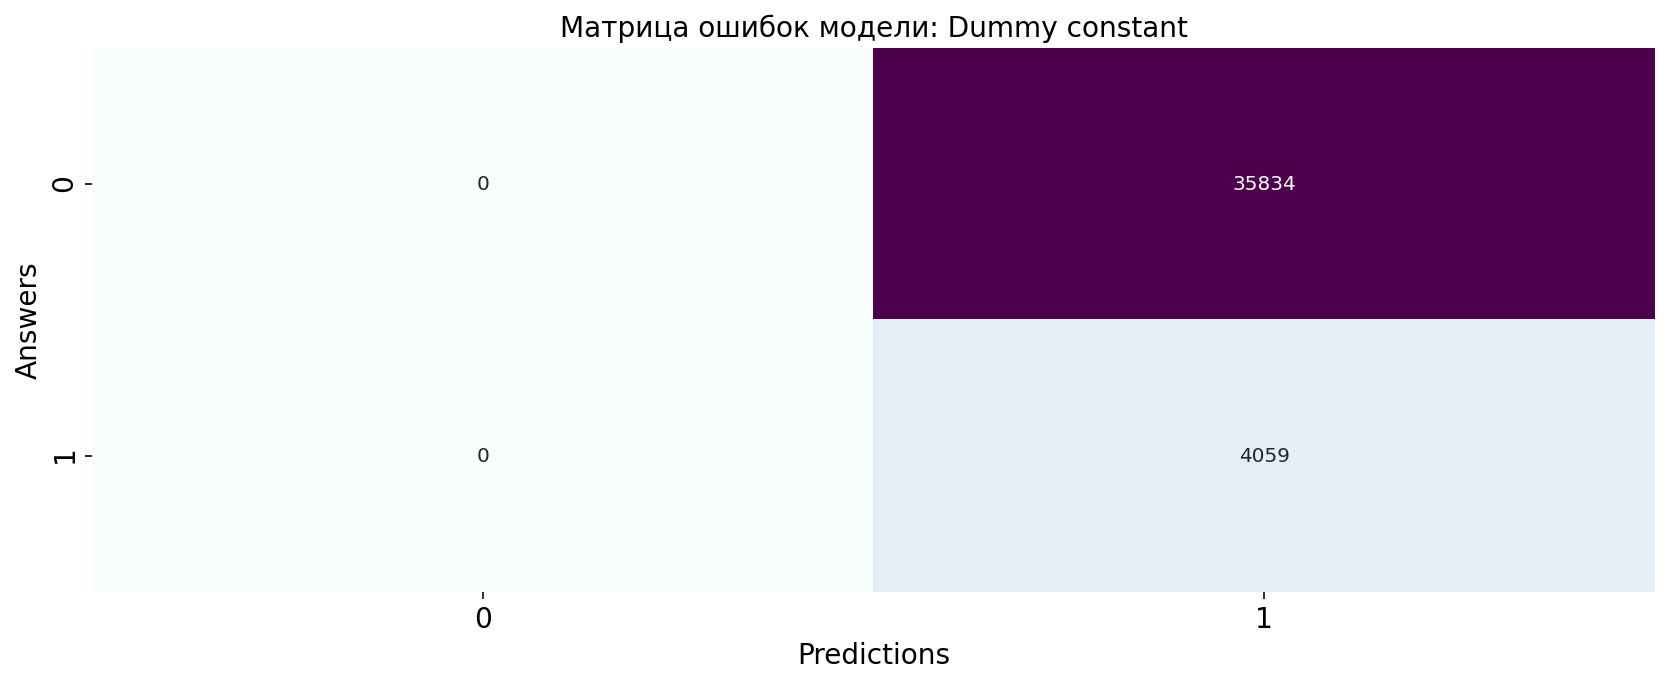

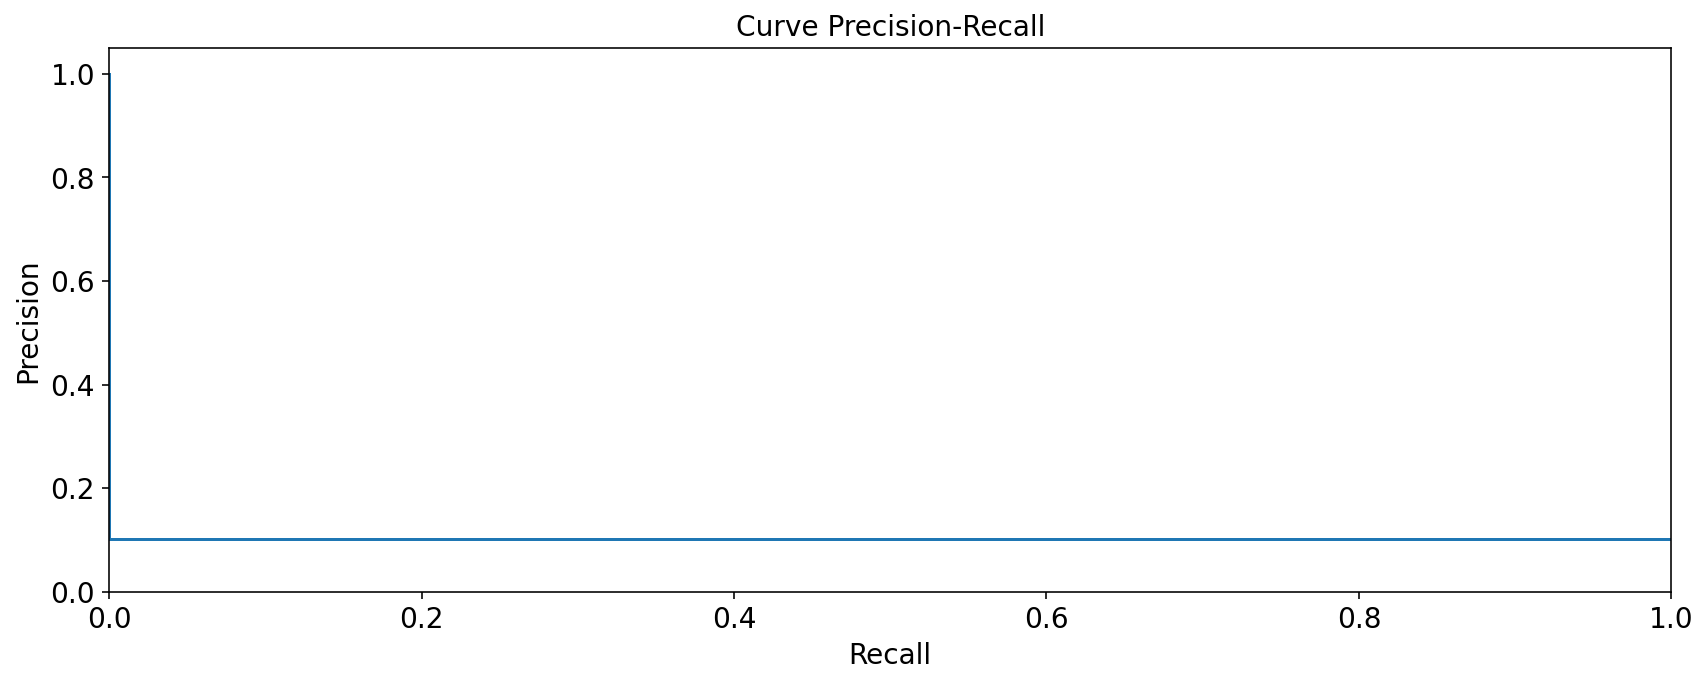

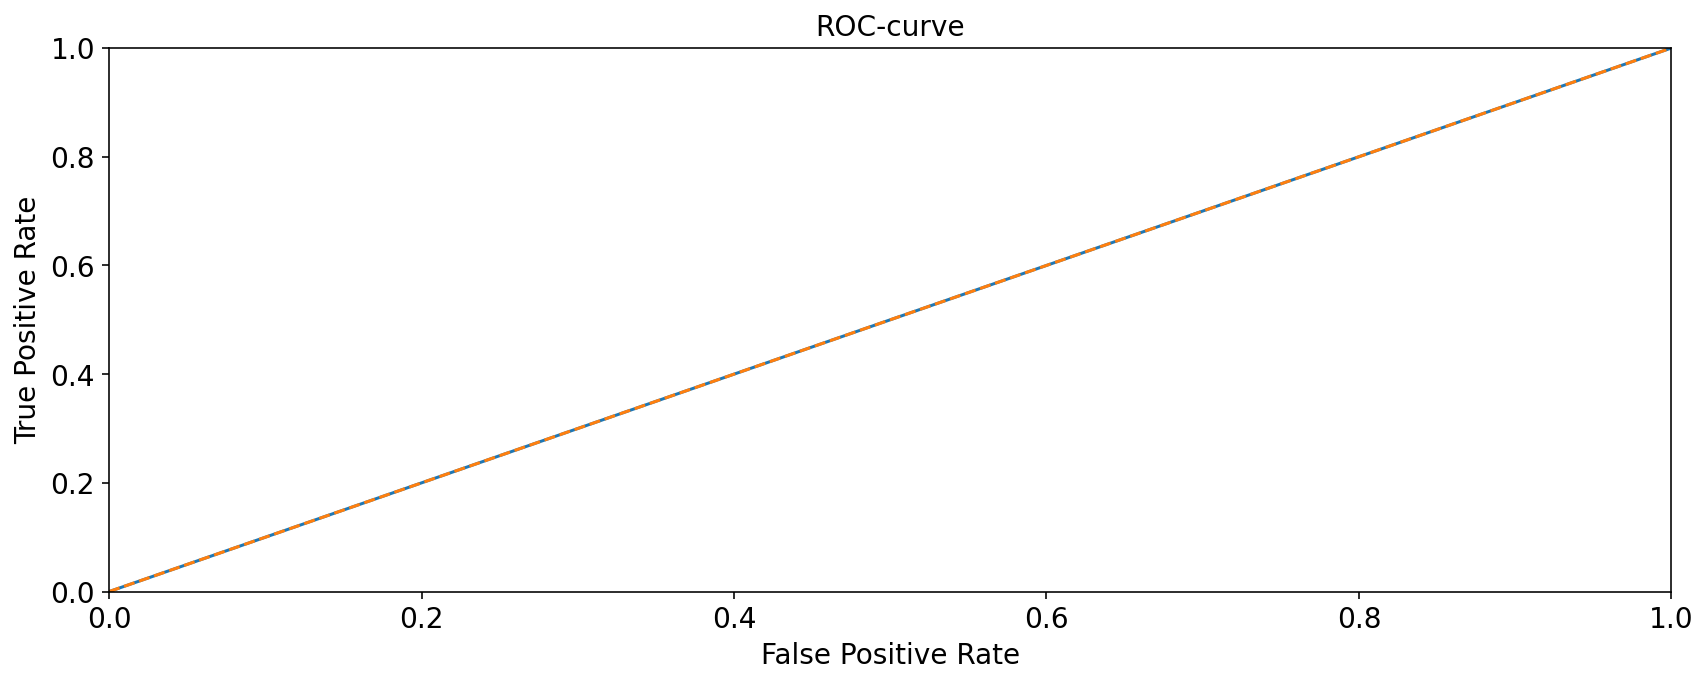


Recall - 1.0
Precision - 0.10174717368961973
F1-Score - 0.1847014925373134
AUC-ROC_score - 0.5

Model has been successfully added!


In [54]:
evaluate_model("Dummy constant", dummy_model, dummy_model.score(features_train,target_train), features_test, target_test)

## Summary
At this stage we researched different ML models: Logistic Regression, Decision Tree, Random Forest, XGBoost, LightGBM. We wrote a function to evaluate the models.  Let's move on to analyzing the results.

<a id="resultsRearchModel"></a>
# Stage 4 - Machine Learning model research

At this stage we will analyze the quality of the models.

The F1 metric is important for business. It must be at least 75.

Let's write an additional function to display the graphs

In [55]:
def drawPlot(df,x_axis, y_axis, x_label, y_label,plot_title, order_by=None):
    """
    Function for plotting graphs 
    df - dataframe
    x_axis
    y_axis
    x_label - label for x axis
    y_label - label for y axis
    plot_title - title 
    order - column by which the order will be determined 
    """
    plt.title(plot_title)
    sns.barplot(x=x_axis,y=y_axis, data=df,order=df[order_by])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

Create the table from the models dictionary

In [56]:
ml_models = pd.DataFrame.from_dict(data=ml_models_stats, orient='index').reset_index(drop=True)
ml_models

,name,train_score,test_score,recall,precision,f1_score,auc_roc_score
0,Logistic Regression,0.963,0.947,0.830,0.702,0.761,0.969
1,Decision Tree,0.592,0.935,0.438,0.856,0.580,0.779
2,Random Forest,0.842,0.880,0.714,0.445,0.548,0.887
3,XGBoost,0.854,0.946,0.730,0.738,0.734,0.932
4,LightGBM,0.932,0.947,0.769,0.725,0.746,0.947
5,Dummy constant,0.475,0.102,1.000,0.102,0.185,0.500


Models that have passed the sanity test.

In [57]:
approved_models = ml_models.query("f1_score > 0.185")
approved_models

,name,train_score,test_score,recall,precision,f1_score,auc_roc_score
0,Logistic Regression,0.963,0.947,0.830,0.702,0.761,0.969
1,Decision Tree,0.592,0.935,0.438,0.856,0.580,0.779
2,Random Forest,0.842,0.880,0.714,0.445,0.548,0.887
3,XGBoost,0.854,0.946,0.730,0.738,0.734,0.932
4,LightGBM,0.932,0.947,0.769,0.725,0.746,0.947


All models have passed the sanity test. Let's find the best model according to the F1 metric on the test sample

,name,f1_score
0,Logistic Regression,0.761
1,LightGBM,0.746
2,XGBoost,0.734
3,Decision Tree,0.580
4,Random Forest,0.548


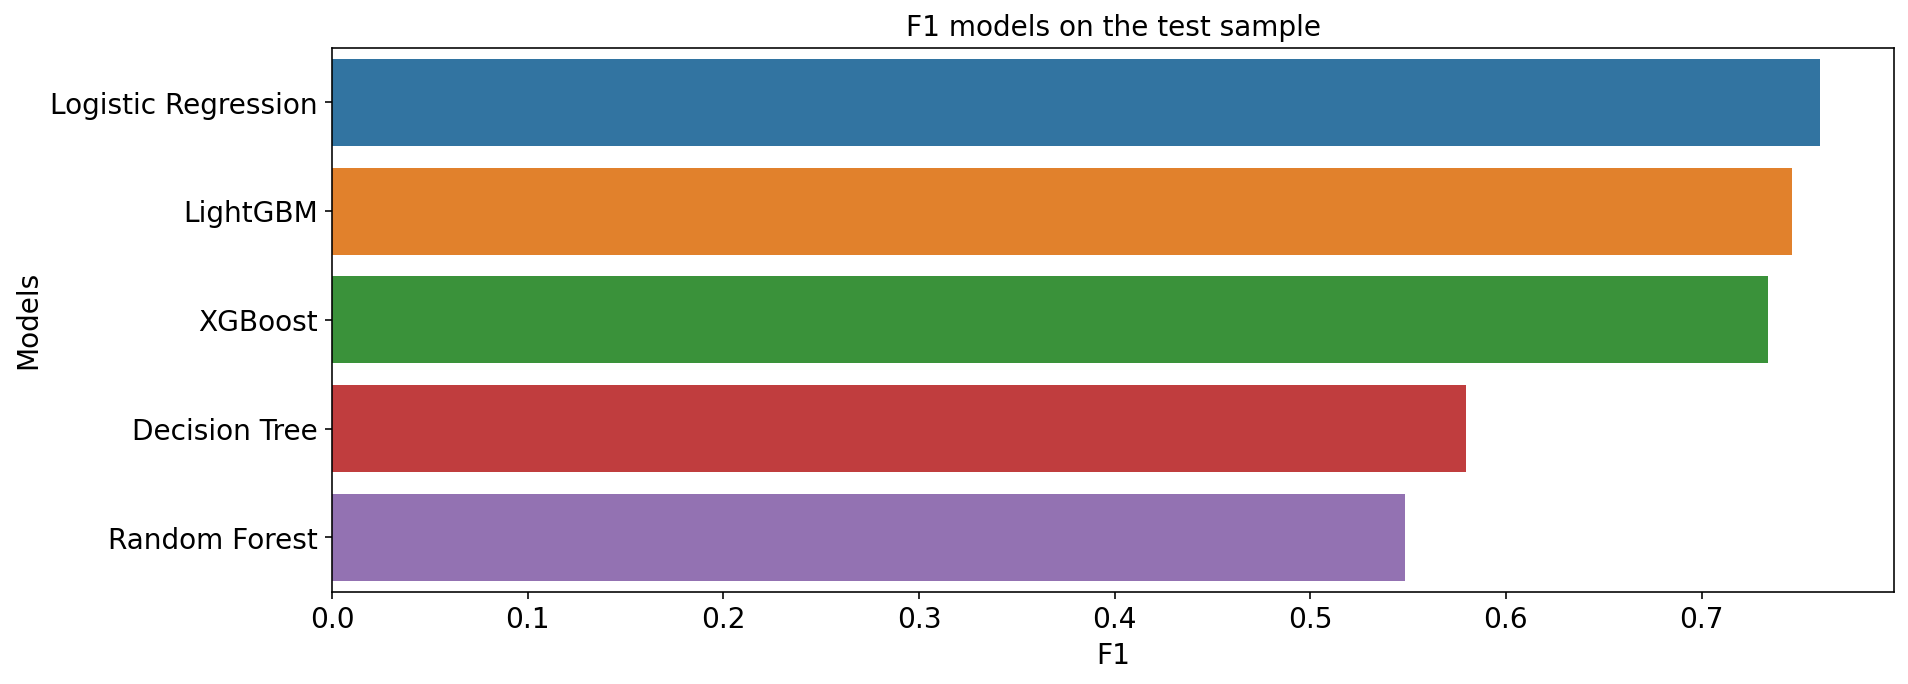

In [58]:
f1_test_sorted = approved_models.sort_values(by='f1_score',ascending=False).reset_index()
display(f1_test_sorted[['name','f1_score']])
drawPlot(f1_test_sorted,'f1_score','name','F1','Models','F1 models on the test sample','name')

The best model was **Logistic Regression** with a score of **0.761** on the test sample.

Businesses want models that have an F1 metric of at least 75. We have one model that meets a business requirement - **Logistic Regression**.

<a id="results"></a>
# Stage 5 - Results

In the project, we successfully built a model that classifies comments into positive and negative ones. By doing so, we helped the business build a system to find toxic comments and send them for modernization. In the project we did:
1. Preprocess data:
    - made lemmatization
    - removed special characters, numbers. 
    - vectorized the texts. 
    - divided the sample into 75/25 - (training and test sample).
2. Machine Learning model research:
    - we researched different ML models: 
        - Logistic Regression
        - Decision Tree
        - Random Forest
        - XGBoost
        - LightGBM.
    - We wrote a function to evaluate the models. 
3. Summarized the results of research:
    - The best model was **Logistic Regression** with a score of **0.761** on the test sample.
    - Businesses want models that have an F1 metric of at least 75. We have one model that meets a business requirement - **Logistic Regression**.